In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [16]:
## Functions
def getRaceResult(runner_id, raceName):
    race_distance_miles = race_distances_df.loc[race_distances_df['Race'] == raceName, 'Distance (miles)'].values[0]
    runner_data = run_train_data[run_train_data['athlete'] == runner_id]
    runner_data = runner_data.sort_values(by='timestamp', ascending=True)
    first_run_at_or_beyond_distance = runner_data[runner_data['distance (m)'] >= race_distances_df.loc[race_distances_df['Race'] == raceName, 'Distance (m)'].values[0]]
    if not first_run_at_or_beyond_distance.empty:
        first_run = first_run_at_or_beyond_distance.iloc[0]
        average_mile_pace = first_run['average pace (min/mile)']
        if pd.notna(average_mile_pace):
            race_time_minutes = race_distance_miles * average_mile_pace
            race_time_hours = race_time_minutes / 60
            return race_time_hours
    return None

def getRaceDate(runner_id, raceName):
    race_distance_m = race_distances_df.loc[race_distances_df['Race'] == raceName, 'Distance (m)'].values[0]
    runner_data = run_train_data[run_train_data['athlete'] == runner_id]
    runner_data = runner_data.sort_values(by='timestamp', ascending=True)
    first_run_at_or_beyond_distance = runner_data[runner_data['distance (m)'] >= race_distance_m]
    if not first_run_at_or_beyond_distance.empty:
        first_run = first_run_at_or_beyond_distance.iloc[0]
        return first_run['timestamp']
    return None

def averagePace(distance_m, time_s):
    distance_miles = distance_m / 1609.34
    time_minutes = time_s / 60
    pace = time_minutes / distance_miles
    return pace

In [3]:
def runModel(race_type):
    ## Drop the NaN values
    training_results_merged_df_dropped = race_runners_dfs[race_type].dropna(subset=['distance (m)', 'elapsed time (s)', 'elevation gain (m)', 'average heart rate (bpm)'])
    training_results_merged_df_dropped = training_results_merged_df_dropped.sort_values(by='timestamp')

    # Select features (X) and target variable (y)
    X = training_results_merged_df_dropped[['distance (m)', 'elapsed time (s)', 'elevation gain (m)']]
    y = training_results_merged_df_dropped[race_type]

    # Determine the split point
    split_index = int(len(X) * 0.8)

    # Split the data into training (80%) and testing (20%) sets
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Initialize the Linear Regression model
    model = LinearRegression()

    # Train the model with the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2
    

In [13]:
def getTrainingWeeksBeforeRace(run_data, race_date, athlete):
    athlete_data = run_data[(run_data['timestamp'] <= race_date) & (run_data['athlete'] == athlete)].copy()
    return athlete_data

def getConsecutiveTrainingWeeks(athlete_data):
    df = pd.DataFrame()

    athlete_data['week_diff'] = athlete_data['week'].astype(np.int64).diff().fillna(999)
    athlete_data['week_diff'] = athlete_data['week_diff'].apply(lambda x: x + 52 if x < 0 and x > -52 else x)
    athlete_data.loc[:, 'consecutive_week_flag'] = (athlete_data['week_diff'] <= 1).astype(int)

    for index, row in athlete_data.iterrows():
        if row['consecutive_week_flag'] == 1:
            df = pd.concat([df, row.to_frame().T])
        else:
            df = pd.DataFrame()
    return df 

def getTrainingData(run_data, race_date, athlete):
    training_data = getTrainingWeeksBeforeRace(run_data, race_date, athlete)
    consecutive_training_data = getConsecutiveTrainingWeeks(training_data)
    return consecutive_training_data


def getTrainingMetrics(athlete_training_data):
    # Calculate metrics
    training_weeks_sum = athlete_training_data['athlete'].count()
    training_distance_sum = athlete_training_data['distance (miles)'].sum()
    training_time_sum = athlete_training_data['elapsed time (hrs)'].sum()
    training_elevation_gain_sum = athlete_training_data['elevation gain (m)'].sum()
    
    weekly_run_count_mean = athlete_training_data.groupby('week').size().mean()
    weekly_run_count_std = athlete_training_data.groupby('week').size().std()
    
    weekly_distance_mean = athlete_training_data.groupby('week')['distance (miles)'].sum().mean()
    weekly_distance_std = athlete_training_data.groupby('week')['distance (miles)'].sum().std()
    
    weekly_time_mean = athlete_training_data.groupby('week')['elapsed time (hrs)'].sum().mean()
    weekly_time_std = athlete_training_data.groupby('week')['elapsed time (hrs)'].sum().std()
    
    weekly_pace_mean = athlete_training_data.groupby('week')['average pace (min/mile)'].mean().mean()
    weekly_pace_std = athlete_training_data.groupby('week')['average pace (min/mile)'].mean().std()
    
    return {
        'training_weeks_sum': training_weeks_sum,
        'training_distance_sum': training_distance_sum,
        'training_time_sum': training_time_sum,
        'training_elevation_gain_sum': training_elevation_gain_sum,
        'weekly_run_count_mean': weekly_run_count_mean,
        'weekly_run_count_std': weekly_run_count_std,
        'weekly_distance_mean': weekly_distance_mean,
        'weekly_distance_std': weekly_distance_std,
        'weekly_time_mean': weekly_time_mean,
        'weekly_time_std': weekly_time_std,
        'weekly_pace_mean': weekly_pace_mean,
        'weekly_pace_std': weekly_pace_std
    }

In [14]:
def calculate_consecutive_weeks(run_train_data, race_date):
    consecutive_weeks = 0
    for index, row in run_train_data.iterrows():
        if row['consecutive_week_flag'] == 1:
            consecutive_weeks += 1
        else:
            consecutive_weeks = 0
        if row['timestamp'] == race_date:
            return consecutive_weeks
    return consecutive_weeks


def getConsecutiveTrainingWeeksOLD(run_train_data, race_date, athlete):
    
    # Filter data for the specified athlete up until the race date
    filtered_data = run_train_data[(run_train_data['timestamp'] <= race_date) & (run_train_data['athlete'] == athlete)].copy()
    
    filtered_data.drop_duplicates(subset=['week'], keep='first', inplace=True)
    filtered_data['week_diff'] = filtered_data.groupby('athlete')['week'].diff().fillna(0)
    filtered_data['week_diff'] = np.where(filtered_data['week_diff'] < 0, filtered_data['week_diff'] + 52, filtered_data['week_diff'])
    filtered_data['consecutive_week_flag'] = (filtered_data['week_diff'] == 1).astype(int)
    
    consecutive_training_weeks = calculate_consecutive_weeks(filtered_data, race_date)
    
    return consecutive_training_weeks


## Writing out some sudo code

def getTrainingWeeks(run_train_data, race_date, athlete):
    # Filter data for the specified athlete up until the race date
    filtered_data = run_train_data[(run_train_data['timestamp'] <= race_date) & (run_train_data['athlete'] == athlete)].copy()
    filtered_data.drop_duplicates(subset=['week'], keep='first', inplace=True)
    filtered_data['week_diff'] = filtered_data.groupby('athlete')['week'].diff().fillna(0)
    filtered_data['week_diff'] = np.where(filtered_data['week_diff'] < 0, filtered_data['week_diff'] + 52, filtered_data['week_diff'])
    filtered_data['consecutive_week_flag'] = (filtered_data['week_diff'] == 1).astype(int)

In [15]:
def getRace(run_race_data, race_name):
    race_data = run_race_data[['athlete', race_name + '_result', race_name + '_race_date']]
    race_data = race_data.dropna(subset=[race_name + '_result'])
    return race_data

In [23]:
## Basic info about types of races
race_distances = {
    'Race': ['5K', '10K', 'Half Marathon', 'Marathon','50K', '50M', '100K'],
    'Distance (miles)': [3.10686, 6.21371, 13.1094, 26.2188, 31.0686, 50, 62.1371],
    'Distance (m)': [4970, 9656, 21097, 42195, 49700, 80467, 100320]
}

race_distances_df = pd.DataFrame(race_distances)

race_distances_df.head(10)

,Race,Distance (miles),Distance (m)
0,5K,3.10686,4970
1,10K,6.21371,9656
2,Half Marathon,13.10940,21097
3,Marathon,26.21880,42195
4,50K,31.06860,49700
5,50M,50.00000,80467
6,100K,62.13710,100320


In [5]:
## Run training data for each runner
run_train_data = pd.read_csv('raw-data-kaggle.csv', delimiter=';')

run_train_data['distance (miles)'] = run_train_data['distance (m)'] * 0.000621371
run_train_data['elapsed time (hrs)'] = run_train_data['elapsed time (s)'] / 3600
run_train_data['average pace (min/mile)'] = (run_train_data['elapsed time (s)'] / 60) / run_train_data['distance (miles)']

run_train_data['timestamp'] = pd.to_datetime(run_train_data['timestamp'], dayfirst=True)
run_train_data['day'] = run_train_data['timestamp'].dt.day
run_train_data['year'] = run_train_data['timestamp'].dt.year
run_train_data['week'] = run_train_data['timestamp'].dt.isocalendar().week

run_train_data.sort_values(by=['athlete', 'year', 'week', 'day'], ascending=[True, True, True, True], inplace=True)

run_train_data['male'] = run_train_data['gender'].apply(lambda x: 1 if x == 'M' else 0)
run_train_data['female'] = run_train_data['gender'].apply(lambda x: 1 if x == 'F' else 0)
run_train_data = run_train_data.drop('gender', axis=1)

run_train_data.head()

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),distance (miles),elapsed time (hrs),average pace (min/mile),day,year,week,male,female
9519,771514,2015-09-17 15:19:00,3927.8,3484,29.2,NaN,2.440621,0.967778,23.791759,17,2015,38,1,0
9518,771514,2015-10-29 18:40:00,1391.1,644,32.1,NaN,0.864389,0.178889,12.417246,29,2015,44,1,0
9517,771514,2016-07-11 11:58:00,2116.8,779,0.0,NaN,1.315318,0.216389,9.870869,11,2016,28,1,0
9516,771514,2017-02-15 16:25:00,5355.4,3371,81.6,NaN,3.327690,0.936389,16.883583,15,2017,7,1,0
9515,771514,2017-06-26 17:31:00,2110.3,683,6.0,NaN,1.311279,0.189722,8.681090,26,2017,26,1,0


In [6]:
run_race_data = pd.DataFrame()

# Add each unique value in run_train_data['athlete'] to run_race_data
run_race_data['athlete'] = run_train_data['athlete'].unique()

## Add a new column for each race type with the result as its value or NaN if the runner did not complete that race
for race in race_distances_df['Race']:
    run_race_data[race + '_result'] = np.nan
    run_race_data[race + '_race_date'] = np.nan

for race in race_distances_df['Race']:
    run_race_data[race + '_race_date'] = pd.to_datetime(run_race_data[race + '_race_date'], errors='coerce')

for runner_id in run_train_data['athlete'].unique():
    for race in race_distances_df['Race']:
        result = getRaceResult(runner_id, race)
        race_date = getRaceDate(runner_id, race)
        run_race_data.loc[run_race_data['athlete'] == runner_id, race + '_result'] = result
        run_race_data.loc[run_race_data['athlete'] == runner_id, race + '_race_date'] = race_date

run_race_data.head()

,athlete,5K_result,5K_race_date,10K_result,10K_race_date,Half Marathon_result,Half Marathon_race_date,Marathon_result,Marathon_race_date,50K_result,50K_race_date,50M_result,50M_race_date,100K_result,100K_race_date
0,771514,0.874249,2017-02-15 16:25:00,1.009510,2017-07-12 16:55:00,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
1,1776170,0.460295,2012-11-05 17:50:00,0.941100,2012-11-06 20:12:00,1.566968,2013-10-27 09:59:00,3.207050,2013-11-24 08:00:00,8.342531,2016-07-16 06:00:00,NaN,NaT,NaN,NaT
2,2013538,0.549371,2015-10-18 08:52:00,1.098740,2015-10-18 08:52:00,2.788450,2018-05-27 06:59:00,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
3,2081128,0.475112,2013-04-21 08:03:00,0.955490,2013-05-05 07:15:00,2.142375,2015-05-10 07:09:00,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
4,2138770,0.789604,2014-05-19 08:08:00,1.579204,2014-05-19 08:08:00,3.331733,2014-05-19 08:08:00,5.981852,2016-05-07 05:43:00,8.165714,2017-05-26 03:00:00,11.836341,2018-06-22 21:05:00,14.709518,2018-06-22 21:05:00


In [22]:
run_race_data_half_marathon = getRace(run_race_data, 'Half Marathon')

run_race_data_half_marathon['male'] = run_race_data_half_marathon['athlete'].apply(lambda x: run_train_data[run_train_data['athlete'] == x]['male'].iloc[0])
run_race_data_half_marathon['female'] = run_race_data_half_marathon['athlete'].apply(lambda x: run_train_data[run_train_data['athlete'] == x]['female'].iloc[0])

run_race_data_half_marathon = run_race_data_half_marathon.dropna(subset=['Half Marathon_result'])
run_race_data_half_marathon.head()

,athlete,Half Marathon_result,Half Marathon_race_date,male,female
1,1776170,1.566968,2013-10-27 09:59:00,1,0
2,2013538,2.788450,2018-05-27 06:59:00,1,0
3,2081128,2.142375,2015-05-10 07:09:00,1,0
4,2138770,3.331733,2014-05-19 08:08:00,1,0
5,2683270,1.520652,2015-06-07 07:01:00,1,0


In [18]:
# Filter data for the specified athlete up until the race date
athlete_data_full = run_train_data[(run_train_data['timestamp'] <= '2016-06-05 07:15:00') & (run_train_data['athlete'] == 11284478)].copy()

# Calculate the difference in weeks, cast to int64 to handle potential negative differences
athlete_data_full['week_diff'] = athlete_data_full['week'].astype(np.int64).diff().fillna(999)
athlete_data_full['week_diff'] = athlete_data_full['week_diff'].apply(lambda x: x + 52 if x < 0 and x > -52 else x)
athlete_data_full.loc[:, 'consecutive_week_flag'] = (athlete_data_full['week_diff'] <= 1).astype(int)

athlete_data_full.head()

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),distance (miles),elapsed time (hrs),average pace (min/mile),day,year,week,male,female,week_diff,consecutive_week_flag
32101,11284478,2014-12-29 11:19:00,5645.2,2116,0.0,NaN,3.507764,0.587778,10.053889,29,2014,1,1,0,999.0,0
32105,11284478,2014-12-20 19:07:00,9370.7,2879,51.6,NaN,5.822681,0.799722,8.240763,20,2014,51,1,0,50.0,0
32106,11284478,2014-12-20 18:38:00,1941.1,711,17.7,152.1,1.206143,0.197500,9.824704,20,2014,51,1,0,0.0,1
32104,11284478,2014-12-21 16:19:00,4858.9,1814,23.8,147.1,3.019180,0.503889,10.013758,21,2014,51,1,0,0.0,1
32103,11284478,2014-12-24 08:41:00,9595.9,8584,979.6,NaN,5.962614,2.384444,23.993951,24,2014,52,1,0,1.0,1


In [21]:
athlete_half_marathon_training_data = getTrainingData(run_train_data, '2015-04-18 07:17:00', 11284478)

training_weeks_sum = athlete_half_marathon_training_data['athlete'].count()
training_distance_sum = athlete_half_marathon_training_data['distance (miles)'].sum()
training_time_sum = athlete_half_marathon_training_data['elapsed time (hrs)'].sum()
training_elevation_gain_sum = athlete_half_marathon_training_data['elevation gain (m)'].sum()

weekly_run_count_mean = athlete_half_marathon_training_data.groupby('week').size().mean()
weekly_run_count_std = athlete_half_marathon_training_data.groupby('week').size().std()

weekly_distance_mean = athlete_half_marathon_training_data.groupby('week')['distance (miles)'].sum().mean()
weekly_distance_std = athlete_half_marathon_training_data.groupby('week')['distance (miles)'].sum().std()

weekly_time_mean = athlete_half_marathon_training_data.groupby('week')['elapsed time (hrs)'].sum().mean()
weekly_time_std = athlete_half_marathon_training_data.groupby('week')['elapsed time (hrs)'].sum().std()

weekly_pace_mean = athlete_half_marathon_training_data.groupby('week')['average pace (min/mile)'].mean().mean()
weekly_pace_std = athlete_half_marathon_training_data.groupby('week')['average pace (min/mile)'].mean().std()

# Print results
print(f"Total number of runs: {training_weeks_sum}")
print(f"Total distance run (miles): {training_distance_sum}")
print(f"Total elapsed time (hrs): {training_time_sum}")
print(f"Total elevation gain (m): {training_elevation_gain_sum}")

print(f"Mean number of runs per week: {weekly_run_count_mean}")
print(f"Standard deviation of weekly run counts: {weekly_run_count_std}")

print(f"Mean weekly distance (miles): {weekly_distance_mean}")
print(f"Standard deviation of weekly distances: {weekly_distance_std}")

print(f"Mean weekly elapsed time (hrs): {weekly_time_mean}")
print(f"Standard deviation of weekly elapsed times: {weekly_time_std}")

print(f"Mean weekly pace (min/mile): {weekly_pace_mean}")
print(f"Standard deviation of weekly pace (min/mile): {weekly_pace_std}")

Total number of runs: 37
Total distance run (miles): 190.7887965579
Total elapsed time (hrs): 36.42916666666667
Total elevation gain (m): 6365.6
Mean number of runs per week: 2.0555555555555554
Standard deviation of weekly run counts: 0.802365782965103
Mean weekly distance (miles): 10.599377586549998
Standard deviation of weekly distances: 4.9376312284254915
Mean weekly elapsed time (hrs): 2.023842592592592
Standard deviation of weekly elapsed times: 1.0870563905862711
Mean weekly pace (min/mile): 11.280297634759897
Standard deviation of weekly pace (min/mile): 2.885467106827181


In [20]:
athlete_summary_data = pd.DataFrame()
athlete_summary_data['training_weeks_sum'] = None
athlete_summary_data['training_distance_sum'] = None
athlete_summary_data['training_time_sum'] = None
athlete_summary_data['training_elevation_gain_sum'] = None
athlete_summary_data['weekly_run_count_mean'] = None
athlete_summary_data['weekly_run_count_std'] = None
athlete_summary_data['weekly_distance_mean'] = None
athlete_summary_data['weekly_distance_std'] = None
athlete_summary_data['weekly_time_mean'] = None
athlete_summary_data['weekly_time_std'] = None
athlete_summary_data['weekly_pace_mean'] = None
athlete_summary_data['weekly_pace_std'] = None

athlete_summary_data.head()

,training_weeks_sum,training_distance_sum,training_time_sum,training_elevation_gain_sum,weekly_run_count_mean,weekly_run_count_std,weekly_distance_mean,weekly_distance_std,weekly_time_mean,weekly_time_std,weekly_pace_mean,weekly_pace_std


/var/folders/vw/yyqdn1290jq54yhkbdwgt8b00000gp/T/ipykernel_11784/764386749.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runner_data['timestamp'] = pd.to_datetime(runner_data['timestamp'], format='%m/%d/%Y %H:%M')


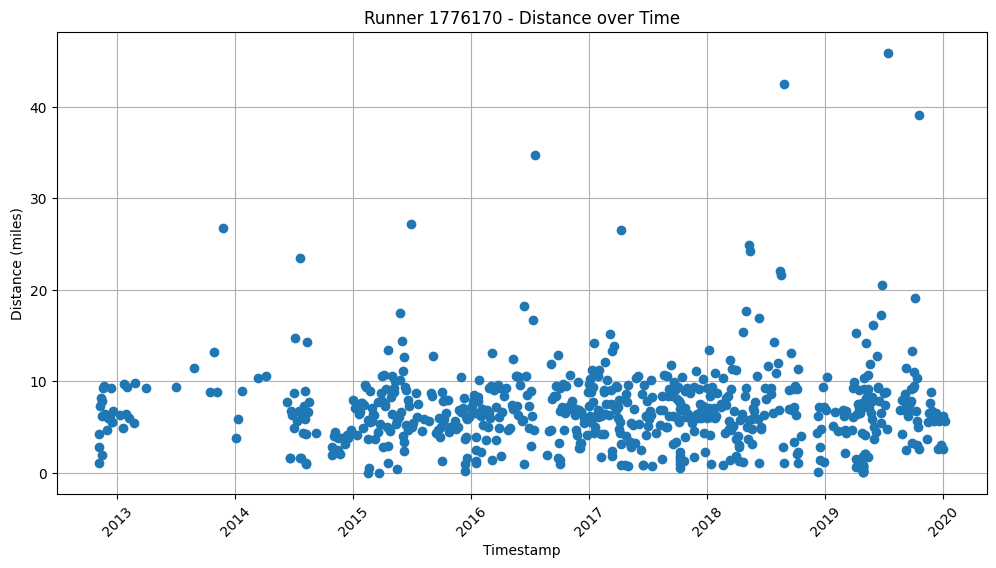

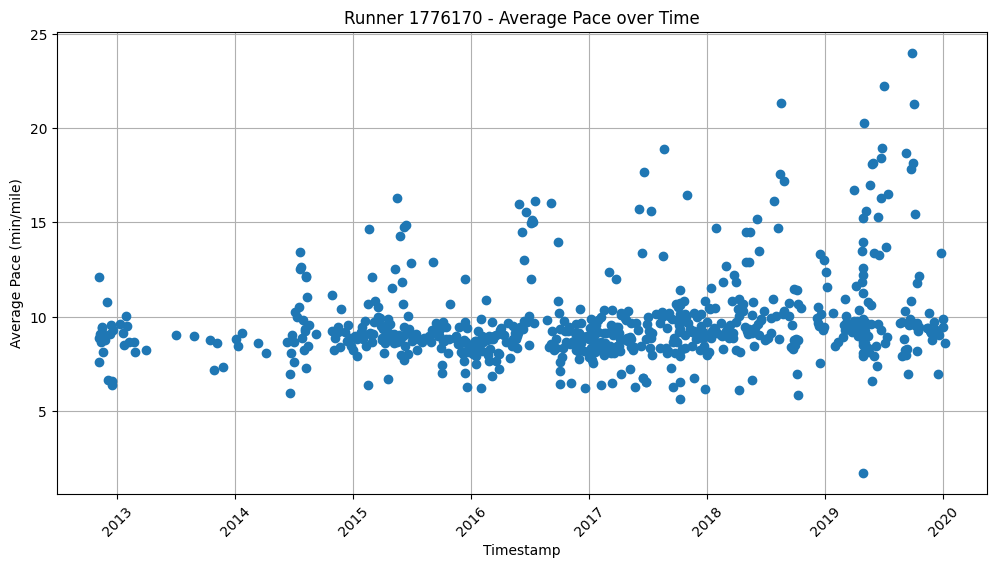

In [19]:
# Select a runner to plot
runner_id = 1776170

# Filter the data for the selected runner
runner_data = run_train_data[run_train_data['athlete'] == runner_id]

# Convert the timestamp to datetime for plotting
runner_data['timestamp'] = pd.to_datetime(runner_data['timestamp'], format='%m/%d/%Y %H:%M')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(runner_data['timestamp'], runner_data['distance (miles)'], marker='o', linestyle='None')
plt.xlabel('Timestamp')
plt.ylabel('Distance (miles)')
plt.title(f'Runner {runner_id} - Distance over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot the average pace per mile
plt.figure(figsize=(12, 6))
plt.plot(runner_data['timestamp'], runner_data['average pace (min/mile)'], marker='o', linestyle='None')
plt.xlabel('Timestamp')
plt.ylabel('Average Pace (min/mile)')
plt.title(f'Runner {runner_id} - Average Pace over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [75]:
# Create separate dataframes for each race type based on the highest race completed by the runner
race_types = ['5K', '10K', 'Half Marathon', 'Marathon', '50K', '50M', '100K']

# Initialize an empty dictionary to store the dataframes
race_runners_dfs = {}

# Iterate through each race type and create a dataframe for runners whose highest completed race is that type
for race in race_types:
    # Filter runners who have completed the current race type
    race_runners = run_train_data.dropna(subset=[race])
    
    # Check if the current race type is the highest completed race for each runner
    for other_race in race_types:
        if race_types.index(other_race) > race_types.index(race):
            race_runners = race_runners[race_runners[other_race].isna()]
    
    # Store the dataframe in the dictionary
    race_runners_dfs[race] = race_runners

# Access the dataframes using race_runners_dfs['5K'], race_runners_dfs['10K'], etc.
race_runners_dfs['5K'].head()

,athlete,gender,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),time,day,month,year,5K,10K,Half Marathon,Marathon,50K,50M,100K
7824,30467841,M,3480.4,1482,64.9,NaN,16:49:00,27,12,2018,0.550278,NaN,NaN,NaN,NaN,NaN,NaN
7825,30467841,M,5573.3,1981,136.1,NaN,17:09:00,11,10,2018,0.550278,NaN,NaN,NaN,NaN,NaN,NaN
7826,30467841,M,3760.1,1444,36.1,NaN,13:40:00,13,8,2018,0.550278,NaN,NaN,NaN,NaN,NaN,NaN
7827,30467841,M,7218.7,3050,142.9,NaN,13:06:00,11,8,2018,0.550278,NaN,NaN,NaN,NaN,NaN,NaN
7828,30467841,M,5888.4,2216,60.0,NaN,17:03:00,14,7,2018,0.550278,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# Run the model for each race type and print the results
for race in race_types:
    mse, r2 = runModel(race)
    print(f'Race Type: {race}')
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print('---')

KeyError: 'timestamp'

This was the results from the first set of data with merged race results.
Mean Squared Error: 3.4519115491222747
R^2 Score: 0.005312515370057724


## Results from only the source data features
Race Type: 5K
Mean Squared Error: 1.232595164407831e-32
R^2 Score: 0.0
---
Race Type: 10K
Mean Squared Error: 0.047388928185275486
R^2 Score: 0.08935285083748334
---
Race Type: Half Marathon
Mean Squared Error: 0.8170558205393661
R^2 Score: -0.0012955886806558237
---
Race Type: Marathon
Mean Squared Error: 3.1623861291863853
R^2 Score: 0.041607053936431604
---
Race Type: 50K
Mean Squared Error: 2.0892964679226824
R^2 Score: -0.01893250091885057
---
Race Type: 50M
Mean Squared Error: 0.0
R^2 Score: 1.0
---
Race Type: 100K
Mean Squared Error: 7.888609052210118e-31
R^2 Score: 0.75
---

In [33]:
# Display the model coefficients
coefficients = model.coef_
feature_names = X.columns

for feature, coef in zip(feature_names, coefficients):
    print(f'{feature}: {coef}')

distance (m): -2.2801244016725836e-05
elapsed time (s): 5.141540391086153e-05
elevation gain (m): 0.00016101170928957878
average heart rate (bpm): 0.004526336574417813


In [29]:
# Create a pipeline with feature scaling and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Fit the pipeline with the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

Mean Squared Error: 3.4519115491222747
R^2 Score: 0.005312515370057724
